## Imports and data loading

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE
from sklearn.svm import SVR
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Bidirectional, TimeDistributed
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, History
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size": 10,
})

def RMSE(true, predicted):
    MSE_score = MSE(true, predicted)
    return np.round(np.sqrt(MSE_score), decimals=4)

In [164]:
# Training data
training_df = pd.read_csv("entsoe_dataset_main_test.csv")[["NO5_day_ahead_prices", "NO5_generation_actual","NO5_Actual Load", "dato_id"]][0:-8760]; print(training_df.shape)

scaler = MinMaxScaler()

print("***",training_df["NO5_day_ahead_prices"].values.reshape(-1,1).shape)

training_df["NO5_day_ahead_prices"] = scaler.fit_transform(training_df["NO5_day_ahead_prices"].values.reshape(-1,1))
training_df["NO5_generation_actual"] = scaler.fit_transform(training_df["NO5_generation_actual"].values.reshape(-1,1))
training_df["NO5_Actual Load"] = scaler.fit_transform(training_df["NO5_Actual Load"].values.reshape(-1,1))

# Forecast solutions
training_df, forcast_sol_df = train_test_split(training_df, shuffle=False, test_size=0.2, random_state=4155)

# Displaying the loaded data
display(training_df.tail(3))
print(training_df.shape)
display(forcast_sol_df.head(3))
print(forcast_sol_df.shape)

print(training_df.max())
print(training_df.min())
print(forcast_sol_df.max())
print(forcast_sol_df.min())

(42766, 4)
*** (42766, 1)


,NO5_day_ahead_prices,NO5_generation_actual,NO5_Actual Load,dato_id
34209,0.361443,0.357568,0.401107,2019-12-04 06:00:00+01:00
34210,0.382525,0.618298,0.461704,2019-12-04 07:00:00+01:00
34211,0.393066,0.703987,0.449093,2019-12-04 08:00:00+01:00


(34212, 4)


,NO5_day_ahead_prices,NO5_generation_actual,NO5_Actual Load,dato_id
34212,0.388884,0.672827,0.432790,2019-12-04 09:00:00+01:00
34213,0.381915,0.630212,0.429406,2019-12-04 10:00:00+01:00
34214,0.378169,0.588361,0.415257,2019-12-04 11:00:00+01:00


(8554, 4)
NO5_day_ahead_prices                           1.0
NO5_generation_actual                          1.0
NO5_Actual Load                                1.0
dato_id                  2019-12-04 08:00:00+01:00
dtype: object
NO5_day_ahead_prices                       0.01751
NO5_generation_actual                          0.0
NO5_Actual Load                                0.0
dato_id                  2016-01-01 01:00:00+01:00
dtype: object
NO5_day_ahead_prices                      0.476174
NO5_generation_actual                     0.863449
NO5_Actual Load                           0.734851
dato_id                  2020-11-24 23:00:00+01:00
dtype: object
NO5_day_ahead_prices                           0.0
NO5_generation_actual                     0.052238
NO5_Actual Load                           0.091972
dato_id                  2019-12-04 09:00:00+01:00
dtype: object


## Time series data processing

### Sliding window process

In [165]:
def create_time_series_data(raw_train_df, raw_forcast_df, nbf_features, nbf_outputs, column_key, column_suffix="", include_target_outputs=True):

    nbf_columns = nbf_features + nbf_outputs
    
    # Timeseries combining training and solutions
    train_and_forcast_df = pd.concat([raw_train_df, raw_forcast_df], axis=0)
    ts_df_combined, ts_data_combined = sliding_window_algorithm(train_and_forcast_df,nbf_columns, nbf_features, nbf_outputs, column_key, column_suffix, include_target_outputs)
    ts_df_combined.to_csv("timeseries_combined.csv")
    
    # Timeseries training only
    ts_df_train, ts_data_train = sliding_window_algorithm(raw_train_df,nbf_columns, nbf_features, nbf_outputs, column_key, column_suffix, include_target_outputs)
    ts_df_train.to_csv("timeseries_train.csv")
    
    # Forcast solution only
    ts_df_forcast, ts_data_forcast = sliding_window_algorithm(raw_forcast_df,nbf_columns, nbf_features, nbf_outputs, column_key, column_suffix, include_target_outputs)
    ts_df_forcast.to_csv("timeseries_forcast.csv")
    n_forcasts = raw_forcast_df.shape[0]
    training_data_df = ts_df_combined[:-n_forcasts]; print("training_data_df.shape:", training_data_df.shape)
    
    # Adding timestamp to the training data frame 
    train_timestamps_df = raw_train_df["dato_id"][nbf_features:]; 
    if(nbf_outputs>1):
        train_timestamp = train_timestamps_df.to_numpy()[ :(-nbf_outputs)+1]
    else:
        train_timestamp = train_timestamps_df.to_numpy()
    
    training_data_df.insert(0,'dato_id',train_timestamp)
    training_data_df.to_csv("training_data_processed.csv")

    # Adding timestamp to the evaluation data frame
    evaluation_data_df = ts_df_combined[-n_forcasts:]; print("evaluation_data_df:", evaluation_data_df.shape)
    eval_timestamps_df = raw_forcast_df["dato_id"]
    evaluation_data_df.insert(0,'dato_id',eval_timestamps_df.to_numpy())
    evaluation_data_df.to_csv("evaluation_data_processed.csv")
    
    # Creating numerical and trainable data
    y_train = training_data_df.iloc[:, 1+nbf_features:].to_numpy()
    x_train = training_data_df.iloc[:, 1:1+nbf_features].to_numpy()
    
    # Creating numerical evaluation data
    y_test = evaluation_data_df.iloc[:, 1+nbf_features:].to_numpy()
    x_test = evaluation_data_df.iloc[:, 1:1+nbf_features].to_numpy()
    
    return x_train, y_train, x_test, y_test, training_data_df, evaluation_data_df


def sliding_window_algorithm(raw_data_df, nbf_columns, input_window, output_window, column_key, column_suffix, include_target_outputs):
    raw_data = raw_data_df[column_key].to_numpy()
    dim0 = raw_data.shape[0] - (nbf_columns - 1) # Number of time-slices
    dim1 = nbf_columns # Time-step length including input window and output window
    data = np.zeros((dim0,dim1)) # Time series matrix
    data[0, :] = raw_data[:dim1] # First initial sample/time-slice (n equals 0)
    n = 1 # n is the count variable
    
    # Looping through the initial input data and constucting the 
    # time series data based on the sliding window approach. 
    # See the report for more descriptions
    for j in range(dim1, raw_data.shape[0]):
        data[n, :-1] = data[n-1, 1:]
        data[n, nbf_columns-1:] = raw_data[j]
        n += 1

    if include_target_outputs:
        # Creating dataframe    
        feature_names = [f"x{i}_{column_suffix}" for i in range(1,input_window+1)]
        if(output_window > 1):
            output_names = [f"y{i}_{column_suffix}" for i in range(1,output_window+1)]    
        else:
            output_names = [f"y_{column_suffix}"]
        
        time_series_df = pd.DataFrame(data=data, columns=feature_names+output_names)
    else:
        feature_names = [f"x{i}_{column_suffix}" for i in range(1,input_window+2)]
        time_series_df = pd.DataFrame(data=data, columns=feature_names)

    return time_series_df, data

## Create windowed time series data

In [166]:
# Time series slicing parameters
nbf_features = input_window = 12 
nbf_outputs = output_window = 1

# Creating time series traing and evaluation (test) data besed on sliding window approach
x_train_GEN, y_train_GEN, x_test_GEN, y_test_GEN, train_df_GEN, eval_df_GEN = create_time_series_data(training_df, 
                                                                                                    forcast_sol_df, 
                                                                                                    nbf_features, 
                                                                                                    nbf_outputs, 
                                                                                                    column_key="NO5_generation_actual", 
                                                                                                    column_suffix="GEN",
                                                                                                    include_target_outputs=True)
display(train_df_GEN.head())
display(eval_df_GEN.head())

print(x_train_GEN.shape)

training_data_df.shape: (34200, 13)
evaluation_data_df: (8554, 13)


,dato_id,x1_GEN,x2_GEN,x3_GEN,x4_GEN,x5_GEN,x6_GEN,x7_GEN,x8_GEN,x9_GEN,x10_GEN,x11_GEN,x12_GEN,y_GEN
0,2016-01-01 13:00:00+01:00,0.378188,0.361234,0.347946,0.342752,0.357416,0.342752,0.345960,0.355735,0.369024,0.401863,0.433939,0.457156,0.475638
1,2016-01-01 14:00:00+01:00,0.361234,0.347946,0.342752,0.357416,0.342752,0.345960,0.355735,0.369024,0.401863,0.433939,0.457156,0.475638,0.497938
2,2016-01-01 15:00:00+01:00,0.347946,0.342752,0.357416,0.342752,0.345960,0.355735,0.369024,0.401863,0.433939,0.457156,0.475638,0.497938,0.524515
3,2016-01-01 16:00:00+01:00,0.342752,0.357416,0.342752,0.345960,0.355735,0.369024,0.401863,0.433939,0.457156,0.475638,0.497938,0.524515,0.580571
4,2016-01-01 17:00:00+01:00,0.357416,0.342752,0.345960,0.355735,0.369024,0.401863,0.433939,0.457156,0.475638,0.497938,0.524515,0.580571,0.616618


,dato_id,x1_GEN,x2_GEN,x3_GEN,x4_GEN,x5_GEN,x6_GEN,x7_GEN,x8_GEN,x9_GEN,x10_GEN,x11_GEN,x12_GEN,y_GEN
34200,2019-12-04 09:00:00+01:00,0.235528,0.201008,0.155338,0.091187,0.105392,0.111196,0.119139,0.148312,0.181152,0.357568,0.618298,0.703987,0.672827
34201,2019-12-04 10:00:00+01:00,0.201008,0.155338,0.091187,0.105392,0.111196,0.119139,0.148312,0.181152,0.357568,0.618298,0.703987,0.672827,0.630212
34202,2019-12-04 11:00:00+01:00,0.155338,0.091187,0.105392,0.111196,0.119139,0.148312,0.181152,0.357568,0.618298,0.703987,0.672827,0.630212,0.588361
34203,2019-12-04 12:00:00+01:00,0.091187,0.105392,0.111196,0.119139,0.148312,0.181152,0.357568,0.618298,0.703987,0.672827,0.630212,0.588361,0.581488
34204,2019-12-04 13:00:00+01:00,0.105392,0.111196,0.119139,0.148312,0.181152,0.357568,0.618298,0.703987,0.672827,0.630212,0.588361,0.581488,0.544371


(34200, 12)


In [167]:
# Time series slicing parameters
nbf_features = input_window = 12 
nbf_outputs = output_window = 1

# Creating time series traing and evaluation (test) data besed on sliding window approach
x_train_LOAD, y_train_LOAD, x_test_LOAD, y_test_LOAD, train_df_LOAD, eval_df_LOAD = create_time_series_data(training_df, 
                                                                                                    forcast_sol_df, 
                                                                                                    nbf_features, 
                                                                                                    nbf_outputs, 
                                                                                                    column_key="NO5_Actual Load", 
                                                                                                    column_suffix="DEM",
                                                                                                    include_target_outputs=True)
display(train_df_LOAD.head())
display(eval_df_LOAD.head())

print(x_train_LOAD.shape)

training_data_df.shape: (34200, 13)
evaluation_data_df: (8554, 13)


,dato_id,x1_DEM,x2_DEM,x3_DEM,x4_DEM,x5_DEM,x6_DEM,x7_DEM,x8_DEM,x9_DEM,x10_DEM,x11_DEM,x12_DEM,y_DEM
0,2016-01-01 13:00:00+01:00,0.418025,0.407875,0.402953,0.403568,0.411873,0.406952,0.426023,0.444479,0.453091,0.478622,0.490311,0.496155,0.509997
1,2016-01-01 14:00:00+01:00,0.407875,0.402953,0.403568,0.411873,0.406952,0.426023,0.444479,0.453091,0.478622,0.490311,0.496155,0.509997,0.508151
2,2016-01-01 15:00:00+01:00,0.402953,0.403568,0.411873,0.406952,0.426023,0.444479,0.453091,0.478622,0.490311,0.496155,0.509997,0.508151,0.519532
3,2016-01-01 16:00:00+01:00,0.403568,0.411873,0.406952,0.426023,0.444479,0.453091,0.478622,0.490311,0.496155,0.509997,0.508151,0.519532,0.536143
4,2016-01-01 17:00:00+01:00,0.411873,0.406952,0.426023,0.444479,0.453091,0.478622,0.490311,0.496155,0.509997,0.508151,0.519532,0.536143,0.536143


,dato_id,x1_DEM,x2_DEM,x3_DEM,x4_DEM,x5_DEM,x6_DEM,x7_DEM,x8_DEM,x9_DEM,x10_DEM,x11_DEM,x12_DEM,y_DEM
34200,2019-12-04 09:00:00+01:00,0.402338,0.368194,0.344817,0.321132,0.310674,0.303291,0.310981,0.318671,0.330052,0.401107,0.461704,0.449093,0.432790
34201,2019-12-04 10:00:00+01:00,0.368194,0.344817,0.321132,0.310674,0.303291,0.310981,0.318671,0.330052,0.401107,0.461704,0.449093,0.432790,0.429406
34202,2019-12-04 11:00:00+01:00,0.344817,0.321132,0.310674,0.303291,0.310981,0.318671,0.330052,0.401107,0.461704,0.449093,0.432790,0.429406,0.415257
34203,2019-12-04 12:00:00+01:00,0.321132,0.310674,0.303291,0.310981,0.318671,0.330052,0.401107,0.461704,0.449093,0.432790,0.429406,0.415257,0.424485
34204,2019-12-04 13:00:00+01:00,0.310674,0.303291,0.310981,0.318671,0.330052,0.401107,0.461704,0.449093,0.432790,0.429406,0.415257,0.424485,0.409105


(34200, 12)


In [168]:
# Time series slicing parameters
nbf_features = input_window = 12 
nbf_outputs = output_window = 1

# Creating time series traing and evaluation (test) data besed on sliding window approach
x_train, y_train, x_test, y_test, train_df, eval_df = create_time_series_data(training_df, 
                                                                              forcast_sol_df, 
                                                                              nbf_features, 
                                                                              nbf_outputs, 
                                                                              column_key="NO5_day_ahead_prices", 
                                                                              column_suffix="DA",
                                                                              include_target_outputs=True)
print(f"{x_test.shape=}")
print(f"{y_test.shape=}")
print(f"{eval_df.shape=}")
print(eval_df.columns)

# Displaying time series data
train_df.index.name = "t"
display(train_df.head())

# Save the table.
train_df.head().to_csv("time_series_data.csv")


display(eval_df.head())

training_data_df.shape: (34200, 13)
evaluation_data_df: (8554, 13)
x_test.shape=(8554, 12)
y_test.shape=(8554, 1)
eval_df.shape=(8554, 14)
Index(['dato_id', 'x1_DA', 'x2_DA', 'x3_DA', 'x4_DA', 'x5_DA', 'x6_DA',
       'x7_DA', 'x8_DA', 'x9_DA', 'x10_DA', 'x11_DA', 'x12_DA', 'y_DA'],
      dtype='object')


,dato_id,x1_DA,x2_DA,x3_DA,x4_DA,x5_DA,x6_DA,x7_DA,x8_DA,x9_DA,x10_DA,x11_DA,x12_DA,y_DA
t,,,,,,,,,,,,,,
0,2016-01-01 13:00:00+01:00,0.140517,0.137904,0.136423,0.135552,0.137991,0.134594,0.134681,0.133113,0.134855,0.138252,0.141476,0.144525,0.146441
1,2016-01-01 14:00:00+01:00,0.137904,0.136423,0.135552,0.137991,0.134594,0.134681,0.133113,0.134855,0.138252,0.141476,0.144525,0.146441,0.150362
2,2016-01-01 15:00:00+01:00,0.136423,0.135552,0.137991,0.134594,0.134681,0.133113,0.134855,0.138252,0.141476,0.144525,0.146441,0.150362,0.157592
3,2016-01-01 16:00:00+01:00,0.135552,0.137991,0.134594,0.134681,0.133113,0.134855,0.138252,0.141476,0.144525,0.146441,0.150362,0.157592,0.162209
4,2016-01-01 17:00:00+01:00,0.137991,0.134594,0.134681,0.133113,0.134855,0.138252,0.141476,0.144525,0.146441,0.150362,0.157592,0.162209,0.167262


,dato_id,x1_DA,x2_DA,x3_DA,x4_DA,x5_DA,x6_DA,x7_DA,x8_DA,x9_DA,x10_DA,x11_DA,x12_DA,y_DA
34200,2019-12-04 09:00:00+01:00,0.350553,0.346981,0.340883,0.341058,0.340883,0.340622,0.340535,0.340622,0.343671,0.361443,0.382525,0.393066,0.388884
34201,2019-12-04 10:00:00+01:00,0.346981,0.340883,0.341058,0.340883,0.340622,0.340535,0.340622,0.343671,0.361443,0.382525,0.393066,0.388884,0.381915
34202,2019-12-04 11:00:00+01:00,0.340883,0.341058,0.340883,0.340622,0.340535,0.340622,0.343671,0.361443,0.382525,0.393066,0.388884,0.381915,0.378169
34203,2019-12-04 12:00:00+01:00,0.341058,0.340883,0.340622,0.340535,0.340622,0.343671,0.361443,0.382525,0.393066,0.388884,0.381915,0.378169,0.380085
34204,2019-12-04 13:00:00+01:00,0.340883,0.340622,0.340535,0.340622,0.343671,0.361443,0.382525,0.393066,0.388884,0.381915,0.378169,0.380085,0.374684


In [169]:
print(x_train.shape)
x_train = np.concatenate([x_train, x_train_GEN, x_train_LOAD], axis=1)
print(x_train.shape)

print(x_test.shape)
x_test = np.concatenate([x_test, x_test_GEN, x_test_LOAD], axis=1)
print(x_test.shape)

(34200, 12)
(34200, 36)
(8554, 12)
(8554, 36)


In [170]:
print(x_train[0, :])
print(x_test[0, :])

[0.14051747 0.137904   0.13642303 0.13555188 0.13799111 0.13459361
 0.13468072 0.13311264 0.13485495 0.13825246 0.14147574 0.14452478
 0.37818848 0.36123415 0.34794562 0.34275241 0.35741561 0.34275241
 0.34595998 0.35573545 0.36902398 0.40186345 0.43393921 0.45715595
 0.41802522 0.4078745  0.40295294 0.40356813 0.41187327 0.40695171
 0.42602276 0.44447862 0.45309136 0.47862196 0.49031067 0.49615503]
[0.35055318 0.34698144 0.34088335 0.34105758 0.34088335 0.34062201
 0.34053489 0.34062201 0.34367105 0.36144263 0.38252461 0.3930656
 0.23552772 0.2010081  0.15533832 0.0911868  0.10539178 0.11119597
 0.11913854 0.1483122  0.18115167 0.35756835 0.61829846 0.70398656
 0.40233774 0.3681944  0.34481698 0.32113196 0.31067364 0.30329129
 0.31098124 0.31867118 0.33005229 0.40110735 0.46170409 0.44909259]


## Analysing the data 

In [17]:
# Create correlation matrix
corr_matrix = train_df.corr(method='spearman')
# Plot
fig, axs = plt.subplots(1, 1,figsize=(3.5, 2.5))
sns.heatmap(abs(corr_matrix), annot=True, cmap = plt.cm.autumn_r, fmt='.2f', ax=axs)
#axs.set_title(f'Correlation analysis on times series data')

# Save the figure.
fig.savefig("corr_analysis.pdf", bbox_inches='tight')

RuntimeError: latex was not able to process the following string:
b'x1_DA'

Here is the full report generated by latex:
This is pdfTeX, Version 3.141592653-2.6-1.40.23 (MiKTeX 21.8)
entering extended mode
(C:/Users/andre/.matplotlib/tex.cache/5a73965288b22ab0098efe8d8f48840d.tex
LaTeX2e <2021-06-01> patch level 1
L3 programming layer <2021-08-27>
(C:\Users\andre\AppData\Local\Programs\MiKTeX\tex/latex/base\article.cls
Document Class: article 2021/02/12 v1.4n Standard LaTeX document class
(C:\Users\andre\AppData\Local\Programs\MiKTeX\tex/latex/base\size10.clo))
(C:\Users\andre\AppData\Local\Programs\MiKTeX\tex/latex/type1cm\type1cm.sty)
(C:\Users\andre\AppData\Local\Programs\MiKTeX\tex/latex/psnfss\mathpazo.sty)
(C:\Users\andre\AppData\Local\Programs\MiKTeX\tex/latex/cm-super\type1ec.sty
(C:\Users\andre\AppData\Local\Programs\MiKTeX\tex/latex/base\t1cmr.fd))
(C:\Users\andre\AppData\Local\Programs\MiKTeX\tex/latex/base\inputenc.sty)
(C:\Users\andre\AppData\Local\Programs\MiKTeX\tex/latex/geometry\geometry.sty
(C:\Users\andre\AppData\Local\Programs\MiKTeX\tex/latex/graphics\keyval.sty)
(C:\Users\andre\AppData\Local\Programs\MiKTeX\tex/generic/iftex\ifvtex.sty
(C:\Users\andre\AppData\Local\Programs\MiKTeX\tex/generic/iftex\iftex.sty))
(C:\Users\andre\AppData\Local\Programs\MiKTeX\tex/latex/geometry\geometry.cfg))
(C:\Users\andre\AppData\Local\Programs\MiKTeX\tex/latex/base\textcomp.sty)
(C:\Users\andre\AppData\Local\Programs\MiKTeX\tex/latex/psnfss\ot1ppl.fd)
(C:\Users\andre\AppData\Local\Programs\MiKTeX\tex/latex/l3backend\l3backend-dvi
ps.def)
No file 5a73965288b22ab0098efe8d8f48840d.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.19 {\rmfamily x1_
                   DA}
No pages of output.
Transcript written on 5a73965288b22ab0098efe8d8f48840d.log.




RuntimeError: latex was not able to process the following string:
b'x1_DA'

Here is the full report generated by latex:
This is pdfTeX, Version 3.141592653-2.6-1.40.23 (MiKTeX 21.8)
entering extended mode
(C:/Users/andre/.matplotlib/tex.cache/5a73965288b22ab0098efe8d8f48840d.tex
LaTeX2e <2021-06-01> patch level 1
L3 programming layer <2021-08-27>
(C:\Users\andre\AppData\Local\Programs\MiKTeX\tex/latex/base\article.cls
Document Class: article 2021/02/12 v1.4n Standard LaTeX document class
(C:\Users\andre\AppData\Local\Programs\MiKTeX\tex/latex/base\size10.clo))
(C:\Users\andre\AppData\Local\Programs\MiKTeX\tex/latex/type1cm\type1cm.sty)
(C:\Users\andre\AppData\Local\Programs\MiKTeX\tex/latex/psnfss\mathpazo.sty)
(C:\Users\andre\AppData\Local\Programs\MiKTeX\tex/latex/cm-super\type1ec.sty
(C:\Users\andre\AppData\Local\Programs\MiKTeX\tex/latex/base\t1cmr.fd))
(C:\Users\andre\AppData\Local\Programs\MiKTeX\tex/latex/base\inputenc.sty)
(C:\Users\andre\AppData\Local\Programs\MiKTeX\tex/latex/geometry\geometry.sty
(C:\Users\andre\AppData\Local\Programs\MiKTeX\tex/latex/graphics\keyval.sty)
(C:\Users\andre\AppData\Local\Programs\MiKTeX\tex/generic/iftex\ifvtex.sty
(C:\Users\andre\AppData\Local\Programs\MiKTeX\tex/generic/iftex\iftex.sty))
(C:\Users\andre\AppData\Local\Programs\MiKTeX\tex/latex/geometry\geometry.cfg))
(C:\Users\andre\AppData\Local\Programs\MiKTeX\tex/latex/base\textcomp.sty)
(C:\Users\andre\AppData\Local\Programs\MiKTeX\tex/latex/psnfss\ot1ppl.fd)
(C:\Users\andre\AppData\Local\Programs\MiKTeX\tex/latex/l3backend\l3backend-dvi
ps.def)
No file 5a73965288b22ab0098efe8d8f48840d.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.19 {\rmfamily x1_
                   DA}
No pages of output.
Transcript written on 5a73965288b22ab0098efe8d8f48840d.log.




<Figure size 252x180 with 2 Axes>

In [ ]:
y_test[:, 5].shape

# Linear regression model 

#### Creating model

In [18]:
MLR_model = LinearRegression()

#### Training the model

In [19]:
MLR_model.fit(x_train, y_train)

LinearRegression()

#### Prediction

In [20]:
y_hat_MLR = MLR_model.predict(x_test)



# Save the forecast in a CSV file.
forecast_MLR = pd.read_csv("FYS_STK_ForecastTemplate.csv", index_col=0)
forecast_MLR["TIMESTAMP"] = eval_df["dato_id"]
forecast_MLR["FORECAST"] = y_hat_MLR
forecast_MLR.to_csv("FYS_STK_ForecastTemplate-LR.csv")

#### Evaluation

In [21]:
RMSE_MLR = RMSE(y_test, y_hat_MLR)
print(f"Overall model score evaluated on training data using RMSE: {RMSE_MLR}")

Overall model score evaluated on training data using RMSE: 0.0053


-----


# XGBOOST

In [22]:
# fit model
#xgboost = XGBRegressor(objective='reg:squarederror', n_estimators=5000)
xgboost = XGBRegressor(objective='reg:squarederror', eta=0.1)
xgboost.fit(x_train, y_train)
# construct an input for a new preduction
#row = values[-6:].flatten()
# make a one-step prediction
yhat = xgboost.predict(x_test)

print(yhat.shape)
print(y_test.shape)

RMSE_xgboost = RMSE(y_test, yhat)
print(f"Overall model score evaluated on training data using RMSE: {RMSE_xgboost}")

(8554,)
(8554, 1)
Overall model score evaluated on training data using RMSE: 0.0407


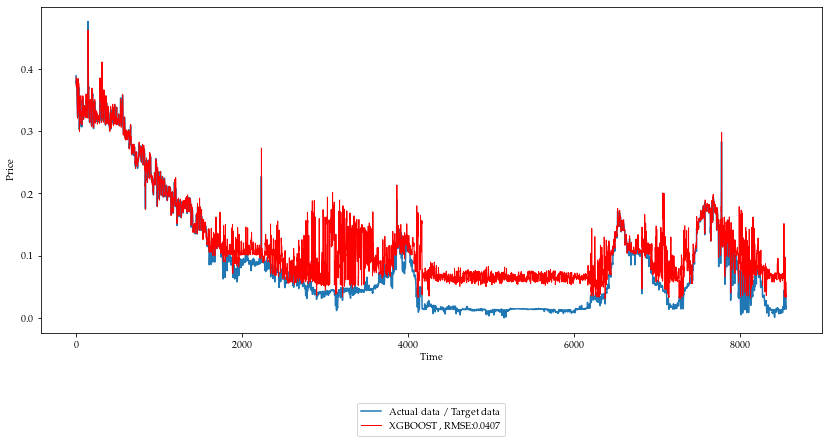

In [23]:
idx_from=0; 
idx_to=720
idx_to = y_test.shape[0]

x_plot = np.arange(x_test.shape[0])

fig, ax = plt.subplots(figsize=(14, 6))
ax.set_xlabel("Time")
ax.set_ylabel("Price")
ax.plot(x_plot[idx_from:idx_to], y_test[idx_from:idx_to], label="Actual data / Target data")
ax.plot(x_plot[idx_from:idx_to], yhat[idx_from:idx_to], c="r",linewidth=1, label=f"XGBOOST , RMSE:{RMSE_xgboost}")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2))



# Save the figure.
plt.savefig("forecast_plot0.pdf", bbox_inches='tight')



# SVR

#### Creating model

In [24]:
SVR_model = SVR(C=1.0, epsilon=0.05) 

#### Training the model

In [25]:
SVR_model.fit(x_train, y_train.flatten()) 

SVR(epsilon=0.05)

#### Prediction

In [26]:
y_hat_SVR = SVR_model.predict(x_test)

print(y_hat_SVR.shape)

# Save the forecast in a CSV file.
forecast_SVR = pd.read_csv("FYS_STK_ForecastTemplate.csv", index_col=0)
forecast_SVR["TIMESTAMP"] = eval_df["dato_id"]
forecast_SVR["FORECAST"] = y_hat_SVR
forecast_SVR.to_csv("FYS_STK_ForecastTemplate-SVR.csv")

(8554,)


#### Evaluation

In [27]:
# Calculation the model score using RMSE
RMSE_SVR = RMSE(y_test, y_hat_SVR)
print(f"Overall model score evaluated on training data using RMSE: {RMSE_SVR}")

Overall model score evaluated on training data using RMSE: 0.0584


# Evaluation results

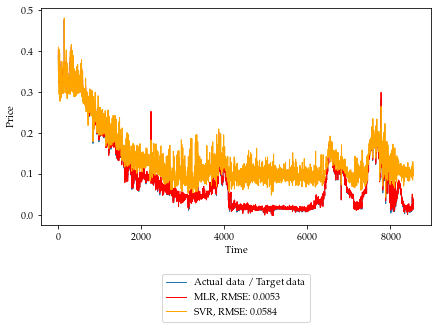

In [28]:
idx_from=0; 
#idx_to=720
idx_to = y_test.shape[0]

x_plot = np.arange(x_test.shape[0])

fig, ax = plt.subplots(figsize=(7, 4))
ax.set_xlabel("Time")
ax.set_ylabel("Price")
ax.plot(x_plot[idx_from:idx_to], y_test[idx_from:idx_to], linewidth=1, label="Actual data / Target data")
ax.plot(x_plot[idx_from:idx_to], y_hat_MLR[idx_from:idx_to], c="r",linewidth=1, label=f"MLR, RMSE: {RMSE_MLR}")
ax.plot(x_plot[idx_from:idx_to], y_hat_SVR[idx_from:idx_to], c="orange", linewidth=1, label=f"SVR, RMSE: {RMSE_SVR}")
#ax.set_title(f"Predicted data using Multiple Linear Regression (MLR) and Support Vector Regression (SVR)")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2))

# Save the figure.
plt.savefig("forecast_plot1.pdf", bbox_inches='tight')

# Neural Networks
We chose to use mean square error as our loss function. Adam is used as the optimizer.

# ANN - Simple architecture

#### Hyperparameters

In [29]:
eta = 0.004
units = 32
batch_size = 500
EPOCHS = 100

#### Model architecture

In [30]:
class ANN_simple(Sequential):
    def __init__(self, eta, units, nbf_outputs):
        super(self.__class__, self).__init__()
       
        self.add(Dense(units, activation='relu')) # First layer
        self.add(Dense(units//2, activation='relu')) # Second layer
        self.add(Dense(nbf_outputs)) # Output layer

        # Model optimizer
        opt = tf.keras.optimizers.Adam(learning_rate=eta)
        
        ## Compile model
        self.compile(loss='mse',  optimizer=opt)

#### Create model

In [31]:
ANN_model1 = ANN_simple(eta, units, nbf_outputs)

#### Preparing data for training and evaluation

In [32]:
# Reshaping the training data for it to fit to the model
x_train_ANN = x_train.reshape((x_train.shape[0],x_train.shape[1],1))
x_train_ANN = np.swapaxes(x_train_ANN,1,2)
y_train_ANN = y_train.copy()

# Reshaping the test data for it to fit to the model
x_test_ANN = x_test.copy()
x_test_ANN = x_test_ANN.reshape((x_test_ANN.shape[0],x_test_ANN.shape[1],1))
x_test_ANN = np.swapaxes(x_test_ANN,1,2)

#### Training the model

In [33]:
ANN_model1.fit(x_train_ANN, y_train_ANN, shuffle=True, batch_size=batch_size, epochs=EPOCHS, verbose=0)
print(ANN_model1.summary())

Model: "ann_simple"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1, 32)             608       
                                                                 
 dense_1 (Dense)             (None, 1, 16)             528       
                                                                 
 dense_2 (Dense)             (None, 1, 1)              17        
                                                                 
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
_________________________________________________________________
None


#### Prediction

In [34]:
y_hat_ANN1 = ANN_model1.predict(x_test_ANN)
y_hat_ANN1 = np.squeeze(y_hat_ANN1) # Removing excess dimensions

# Save the forecast in a CSV file.
forecast_ANN = pd.read_csv("FYS_STK_ForecastTemplate.csv", index_col=0)
forecast_ANN["TIMESTAMP"] = eval_df["dato_id"]
forecast_ANN["FORECAST"] = y_hat_ANN1.flatten()
forecast_ANN.to_csv("FYS_STK_ForecastTemplate-ANN.csv")

#### Evaluation

In [35]:
# Calculation the model score using RMSE
RMSE_ANN1 = RMSE(y_test, y_hat_ANN1)
print(f"Overall model score evaluated on training data using RMSE: {RMSE_ANN1}")

Overall model score evaluated on training data using RMSE: 0.0149


# ANN - Complex architecture

#### Hyperparameters

In [ ]:
decay= 1e-5
eta = 0.005
lam = 0.0001
units = 32
batch_size = 1000
drop = 0.2
EPOCHS=100

#### Model architecture

In [ ]:
class ANN_complex1(Sequential):
    def __init__(self, eta, lam, decay, units, drop,  nbf_outputs):
        super(self.__class__, self).__init__()
       
        # Initialization
        regz = tf.keras.regularizers.l2(lam)
        self.add(Dense(units, kernel_regularizer=regz, activation='relu'))
        self.add(BatchNormalization())
        self.add(Dropout(drop))
        
        self.add(Dense(units*2, kernel_regularizer=regz, activation='relu'))
        self.add(BatchNormalization())
        self.add(Dropout(drop))
        
        self.add(Dense(units*4, kernel_regularizer=regz, activation='relu'))
        self.add(BatchNormalization())
        self.add(Dropout(drop))
        
        self.add(Dense(units*2, kernel_regularizer=regz, activation='relu'))
        self.add(BatchNormalization())
        self.add(Dropout(drop))
        
        self.add(Dense(units//2, kernel_regularizer=regz, activation='relu'))
        self.add(BatchNormalization())
        self.add(Dropout(drop))
          
        self.add(Dense(nbf_outputs))

        # Model optimizer
        opt = tf.keras.optimizers.Adam(learning_rate=eta, decay=decay)
        
        ## Compile model
        self.compile(loss='mse',  optimizer=opt, metrics=[tf.keras.metrics.RootMeanSquaredError()])
        
        tf.keras.backend.clear_session()
        
    
    def fit(self, x_train, y_train, shuffle = True, batch_size = 32, epochs=100,
            validation_split=0.2, verbose=0):
        """
        Wrapper method that builds regularization into the training to 
        intentionally prevent overfitting. This method splits the
        training data into traning and validation such that validation 
        data can be used to validate the model during the traning process.
        """
        learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=6, 
                                            verbose=1, 
                                            factor=0.1, 
                                            min_lr=0.000001)
        earlystop = EarlyStopping(patience=20)
        callbacks = [earlystop, learning_rate_reduction]
        
        return super().fit(x_train, y_train, shuffle=shuffle, batch_size=batch_size, epochs=epochs, 
                      validation_split=validation_split, callbacks= callbacks, verbose=verbose)

#### Create model

In [ ]:
ANN_model2 = ANN_complex1(eta, lam, decay, units, drop, nbf_outputs)

#### Preparing data for training and evaluation

In [ ]:
print(f"x_train.shape:{x_train.shape}, y_train.shape:{y_train.shape}")
# Reshaping the training data for it to fit to the model
x_train_ANN = x_train.reshape((x_train.shape[0],x_train.shape[1],1))
x_train_ANN = np.swapaxes(x_train_ANN,1,2)
y_train_ANN = y_train.copy()

# Reshaping the test data for it to fit to the model
x_test_ANN = x_test.copy()
x_test_ANN = x_test_ANN.reshape((x_test_ANN.shape[0],x_test_ANN.shape[1],1))
x_test_ANN = np.swapaxes(x_test_ANN,1,2)

#### Training the model

In [ ]:
training = ANN_model2.fit(x_train_ANN, y_train_ANN,shuffle=True,batch_size=batch_size, epochs=EPOCHS,
               validation_split=0.1, verbose=0)
print(ANN_model2.summary())

In [ ]:
train_losses = np.array(training.history['loss'])
val_losses = np.array(training.history['val_loss'])
val_rmse = np.array(training.history['val_root_mean_squared_error'])
x = np.arange(train_losses.shape[0])

fig, ax = plt.subplots(figsize=(6, 2))
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss values")
ax.plot(x, train_losses, linewidth=1, label="Training loss")
ax.plot(x, val_losses, linewidth=1, label="Validation loss")
ax.legend(loc="upper center")

plt.savefig("ANN_training.pdf", bbox_inches='tight')

The plot above indicates how the training went. We can see from the plot that the validation loss does not have an increasing trend, and it converge towards the training loss. This shows us that the model is not overfitted to the training data despite the relatively advanced model architecture. 

The model is constructed with regularization; regularizers, dropouts, early stopping, and learning rate reduction. The main purpose of regularization is to prevent underfitting and overfitting of the model and generalize it properly for new previously unseen data. The regularization definitely contributes to the curvature of the losses in the plot. However, it seems that the models we explored for this assignment were not so easy overfitted to the training data. The regularization may have been unnecessary considering the data we have and the setup we are using. 

#### Prediction

In [ ]:
y_hat_ANN2 = ANN_model2.predict(x_test_ANN)
y_hat_ANN2 = np.squeeze(y_hat_ANN2) # Removing excess dimensions

#### Evaluation

In [ ]:
# Calculation the model score using RMSE
RMSE_ANN2 = RMSE(y_test, y_hat_ANN2)
print(f"Overall model score evaluated on test data using RMSE: {RMSE_ANN2}")

# LSTM (RNN)
We are using the LSTM model as our RNN model. The LSTM is configured for a many-to-one problem using a bidirectional wrapper.

#### Hyperparameters

In [218]:
eta = 0.0005
units = 200
batch_size = 100
EPOCHS=50

#### Model architecture

In [219]:
class LSTM_model(Sequential):
    def __init__(self, eta, units, model_shape, nbf_outputs):
        super(self.__class__, self).__init__()
        # regz = tf.keras.regularizers.l2(lam)
        # Bidirectional LSTM layer
        # self.add(Bidirectional(LSTM(units, input_shape = model_shape, kernel_regularizer=regz  ,return_sequences = True)))
        # self.add(LSTM(units, input_shape = model_shape, return_sequences = True))
        self.add(Bidirectional(LSTM(units, input_shape = model_shape, return_sequences = True)))
        #self.add(Bidirectional(LSTM(units, input_shape = model_shape, return_sequences = True)))
                
        # Dense layer
        # self.add(Dense(units, kernel_regularizer=regz, activation='relu'))
        #self.add(Dense(units, activation='relu'))
        
        

        # Output layer
        self.add(Dense(nbf_outputs))

        # Model compile settings
        opt = tf.keras.optimizers.Adam(learning_rate=eta)
        
        ## Compile model
        self.compile(loss='mse', optimizer=opt, metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [220]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.1, 
                                            min_lr=0.000001)
callbacks = [learning_rate_reduction]

#### Model shape
LSTM requires a shape of (batch_size, time_steps, num_features)

In [221]:
time_steps = 72 # 72 hours = 3 days of history per training sequence
nbf_features = x_train.shape[1]
model_shape = (time_steps, nbf_features); print(model_shape)

(72, 36)


#### Create model

In [222]:
RNN_model1 = LSTM_model(eta, units, model_shape, nbf_outputs)

In [223]:
print(x_train.shape[0])
print(x_train.shape[0]%time_steps)
print((x_train.shape[0]-6)/time_steps)

print(x_test.shape[0])
print(x_test.shape[0]%time_steps)
print((x_test.shape[0]-58)/time_steps)

print(y_train[34351-34300: , :].shape)
print(y_test[8592-8540:,:].shape)

34200
0
474.9166666666667
8554
58
118.0
(34149, 1)
(8502, 1)


#### Preparing data for training and evaluation

In [224]:
# Training data pre-processing
train_start_idx = x_train.shape[0]%time_steps
trainX = x_train[train_start_idx: , :] # 
trainY = y_train[train_start_idx: , :] # 

print(x_train.shape)
print(trainX.shape)

batch_size_train = trainX.shape[0] // time_steps
x_train_RNN = trainX.reshape((batch_size_train, time_steps, nbf_features))
y_train_RNN = trainY.copy()
y_train_RNN = y_train_RNN.reshape((batch_size_train, time_steps, nbf_outputs))

# Test data pre-processing
test_start_idx = x_test.shape[0]%time_steps
x_test_ = x_test[test_start_idx:,:]
y_test_ = y_test[test_start_idx:,:]




batch_size_test = x_test_.shape[0] // time_steps
x_test_RNN = x_test_.reshape((batch_size_test, time_steps, nbf_features))
y_test_RNN = y_test_.copy()
y_test_RNN = y_test_RNN.reshape((batch_size_test, time_steps, nbf_outputs))
y_test_RNN = y_test_RNN#.flatten()

print(y_test_RNN.shape)
print(y_test_.shape)

(34200, 36)
(34200, 36)
(118, 72, 1)
(8496, 1)


#### Training the model

In [225]:
RNN_training = RNN_model1.fit(x_train_RNN,  y_train_RNN, 
                              validation_split=0.10, 
                              callbacks= callbacks, 
                              shuffle=False, 
                              batch_size=batch_size, 
                              epochs=EPOCHS, 
                              verbose=0)
print(RNN_model1.summary())



Epoch 00031: ReduceLROnPlateau reducing learning rate to 5.0000002374872565e-05.

Epoch 00039: ReduceLROnPlateau reducing learning rate to 5.000000237487257e-06.

Epoch 00044: ReduceLROnPlateau reducing learning rate to 1e-06.
Model: "lstm_model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_25 (Bidirecti  (None, 72, 400)          379200    
 onal)                                                           
                                                                 
 dense_29 (Dense)            (None, 72, 1)             401       
                                                                 
Total params: 379,601
Trainable params: 379,601
Non-trainable params: 0
_________________________________________________________________
None


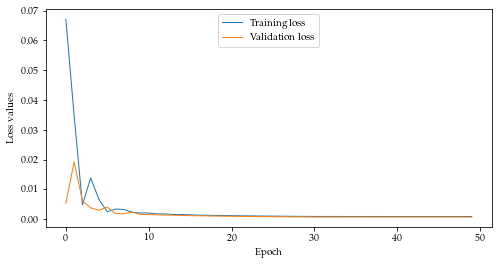

In [226]:
train_losses = np.array(RNN_training.history['loss'])
val_losses = np.array(RNN_training.history['val_loss'])
val_rmse = np.array(RNN_training.history['val_root_mean_squared_error'])
x = np.arange(train_losses.shape[0])

fig, ax = plt.subplots(figsize=(8, 4))
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss values")
ax.plot(x, train_losses, linewidth=1, label="Training loss")
ax.plot(x, val_losses, linewidth=1, label="Validation loss")
ax.legend(loc="upper center")

plt.savefig("RNN_training.pdf", bbox_inches='tight')

#### Prediction

In [227]:

y_hat_RNN1 = RNN_model1.predict(x_test_RNN)
print(y_hat_RNN1[:,:,0].shape)

y_hat_RNN1 = y_hat_RNN1[:,:,0].flatten()

# Save the forecast in a CSV file.
forecast_RNN = pd.read_csv("FYS_STK_ForecastTemplate.csv", index_col=0)
forecast_RNN["TIMESTAMP"] = eval_df["dato_id"][test_start_idx:]
forecast_RNN["FORECAST"] = y_hat_RNN1
forecast_RNN.to_csv("FYS_STK_ForecastTemplate-RNN.csv")

(118, 72)


#### Evaluation

In [228]:
print(y_hat_RNN1.shape)
print(y_test_RNN[:,:,0].flatten().shape)

RMSE_RNN1 = RMSE(y_test_RNN[:,:,0].flatten(), y_hat_RNN1)
print(RMSE_RNN1)

(8496,)
(8496,)
0.0171


# Evaluation results

(8496,)
(8554, 1)


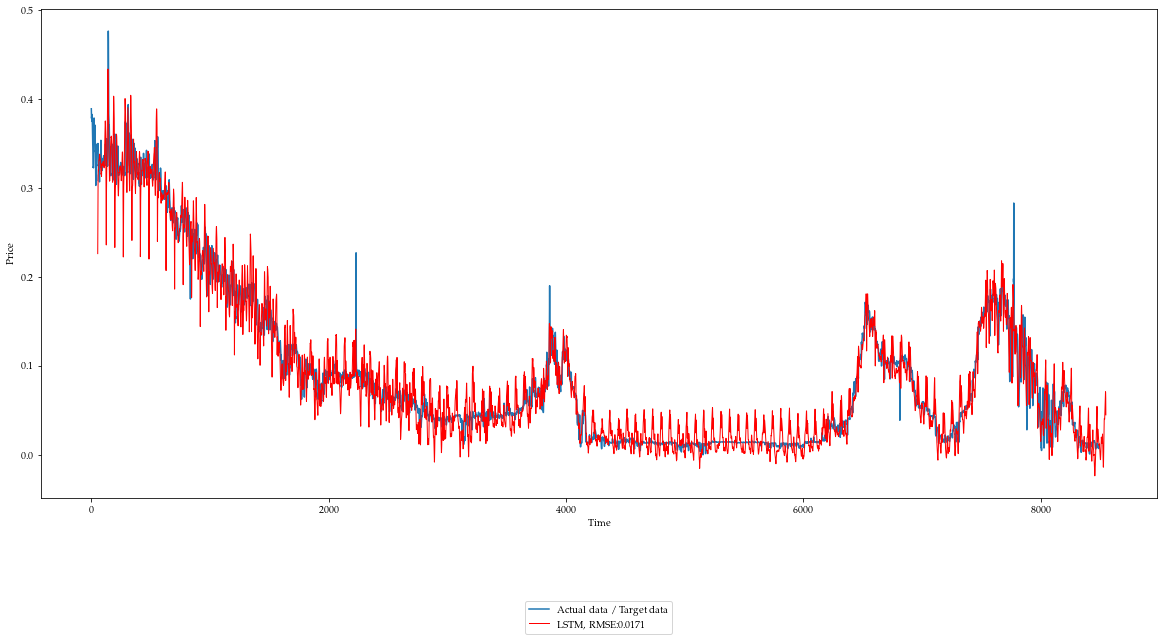

In [229]:
print(y_hat_RNN1.shape)
print(y_test.shape)

idx_from=0; 
# idx_to=700
idx_to=y_hat_RNN1.shape[0]
x_plot = np.arange(y_hat_RNN1.shape[0]+time_steps)

fig, ax = plt.subplots(figsize=(20, 9))
ax.set_xlabel("Time")
ax.set_ylabel("Price")
ax.plot(x_plot[idx_from : idx_to], y_test[idx_from:idx_to, 0], label="Actual data / Target data")
ax.plot(x_plot[idx_from+time_steps-18 : idx_to+time_steps-18], y_hat_RNN1[idx_from:idx_to], c="red", linewidth=1, label=f"LSTM, RMSE:{RMSE_RNN1}")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2))

plt.savefig("RNN_results.pdf", bbox_inches='tight')


# Final results

In [ ]:
data = {'RMSE': [RMSE_MLR, RMSE_SVR, RMSE_ANN1, RMSE_RNN1]}
results = pd.DataFrame.from_dict(data, orient='index',  columns=['MLR', 'SVR', 'ANN', 'RNN'])
results = results.style.background_gradient(cmap='RdYlGn_r',axis=1)
display(results) 

In [ ]:
a = c

-----


# Stateful LSTM (RNN)
We are using the LSTM model as our RNN model
Many-to-one configuration using the stateful flag

#### Hyperparameters

In [ ]:
eta = 0.004
units = 64
batch_size = 1
EPOCHS = 50

#### Model architecture

In [ ]:
# The best performing model
class LSTM_stateful_model(Sequential):
    def __init__(self, eta, units, model_shape, nbf_outputs):
        super(self.__class__, self).__init__()
       
        self.add(Bidirectional(LSTM(units, input_shape=model_shape, stateful=True, return_sequences = True)))
        self.add(Dense(units, activation='relu'))

        # Output layer
        self.add(TimeDistributed(Dense(1)))

        # Model compile settings
        opt = tf.keras.optimizers.Adam(learning_rate=eta)
        
        ## Compile model
        self.compile(loss='mse', optimizer=opt)

#### Model shape
LSTM requires a shape of (batch_size, time_steps, num_features). Stateful models are trained using a fixed batch size of 1 since it uses the hidden state output from the previous batch as input to the initial hidden state for the current batch

In [ ]:
time_steps = 70 # 72 hours = 3 days of history per training sequence
model_shape = (time_steps, nbf_features); print(model_shape)

#### Create model

In [ ]:
RNN_model2 = LSTM_stateful_model(eta, units, model_shape, nbf_outputs)

#### Preparing data for training and evaluation

In [ ]:
# # Time series slicing parameters
# nbf_features = input_window = 24 
# nbf_outputs = output_window = 1

# # Creating time series traing and evaluation (test) data besed on sliding window approach
# x_train, y_train, x_test, y_test, train_df, eval_df = create_time_series_data(training_df, forcast_sol_df, nbf_features, nbf_outputs)


# Training data pre-processing

trainX = x_train[x_train.shape[0]-34300: , :] # Discarding some samples to make the shapes add up
trainY = y_train[y_train.shape[0]-34300: , :] # Discarding some samples to make the shapes add up


batch_size_train = x_train.shape[0] // time_steps
x_train_RNN2 = trainX.reshape((batch_size_train, time_steps, nbf_features))
y_train_RNN2 = trainY.copy()
y_train_RNN2 = y_train_RNN.reshape((batch_size_train, time_steps, nbf_outputs))

print(f"{x_train_RNN2.shape=}")
# Test data pre-processing

x_test_ = x_test[8592-8540:,:]
y_test_ = y_test[8592-8540:,:]

batch_size_test = x_test_.shape[0] // time_steps
x_test_RNN = x_test_.reshape((batch_size_test, time_steps, nbf_features))
y_test_RNN = y_test_.copy()
y_test_RNN = y_test_RNN.reshape((batch_size_test, time_steps, nbf_outputs))
y_test_RNN = y_test_RNN#.flatten()

print(y_test_RNN.shape)
print(y_test_.shape)



# Training data pre-processing
# trainX = x_train[20:] # Discarding some samples to make the shapes add up
# trainY = y_train[20:] # Discarding some samples to make the shapes add up

# batch_size_train = x_train.shape[0] // time_steps
# x_train_RNN2 = trainX.reshape((batch_size_train, time_steps, nbf_features))
# y_train_RNN2 = trainY.copy()
# y_train_RNN2 = y_train_RNN2.reshape((batch_size_train, time_steps, 1))

# # Test data pre-processing
# batch_size_test = x_test.shape[0] // time_steps
# x_test_RNN = x_test.reshape((batch_size_test, time_steps, nbf_features))
# y_test_RNN = y_test.copy()
# y_test_RNN = y_test_RNN.reshape((batch_size_test, time_steps, 1))
# y_test_RNN = y_test_RNN.flatten()

#### Training the model
Stateful LSTMs are trained differently than the default LSTM. Since they carry over the hidden state from batch-to-batch, the batch size must be 1. Shuffle must be false, since the order of the batches matter in the data series. Lastly the hidden state must be reset at the ende of the each epoch, otherwise the hidden state at the end of the dataset will be feed into the starte of the next epoch. You only want batches to be orderly chained, not epochs.  

In [ ]:
for e in range(EPOCHS):
    print(f"Training epoch {e}")
    RNN_model2.fit(x_train_RNN2, y_train_RNN2, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    RNN_model2.reset_states()
print(RNN_model2.summary())

#### Prediction

In [ ]:
y_hat_RNN2 = RNN_model2.predict(x_test_RNN, batch_size=1)
print(y_hat_RNN2.shape)
y_hat_RNN2 = y_hat_RNN2.flatten()

#### Evaluation

In [ ]:
print(y_test_RNN.flatten().shape)
RMSE_RNN2 = RMSE(y_test_RNN.flatten(), y_hat_RNN2)
print(RMSE_RNN2)














# Evaluation results

In [ ]:
idx_from=0; 
idx_to=720
idx_to=y_hat_RNN2.shape[0]
x_plot = np.arange(x_test.shape[0])

fig, ax = plt.subplots(figsize=(7, 4))
ax.set_xlabel("Time")
ax.set_ylabel("Power")
ax.plot(x_plot[idx_from:idx_to], y_test[idx_from:idx_to], linewidth=1, label="Actual data / Target data")
ax.plot(x_plot[idx_from:idx_to], y_hat_RNN2[idx_from:idx_to], c="orange", linewidth=1, label=f"RNN (LSTM), RMSE: {RMSE_RNN1}")
#ax.set_title(f"Predicted data using Artificial Neural Network (ANN) and Recurrent Neural Network (RNN)")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2))

# Save the figure.
plt.savefig("forecast_plot2.pdf", bbox_inches='tight')

# Final results

In [ ]:
data = {'RMSE': [RMSE_MLR, RMSE_SVR, RMSE_ANN1, RMSE_RNN1]}
RMSEs = pd.DataFrame.from_dict(data, orient='index',  columns=['MLR', 'SVR', 'ANN', 'RNN'])
RMSEs_styled = RMSEs.style.background_gradient(cmap='RdYlGn_r',axis=1)
display(RMSEs_styled)

## A table of all relevant RMSEs

In [ ]:
RMSEs = RMSEs.T
RMSEs = RMSEs.rename({"RNN" : "RNN (LSTM)"})
RMSEs.to_csv("q3_RMSE.csv")

----------------------------
# Tests using different window size in the time series data

## Create windowed time series data

In [ ]:
# Training data
training_df = pd.read_csv("entsoe_dataset_main.csv")[["NO5_day_ahead_prices","dato_id"]][0:-8760]; print(training_df.shape)

# Forecast solutions
training_df, forcast_sol_df = train_test_split(training_df, shuffle=False, test_size=0.2, random_state=4155)

nbf_features = window_size = 20
nbf_outputs = 1

# Creating time series traing and evaluation (test) data besed on sliding window approach
x_train, y_train, x_test, y_test, train_df, eval_df = create_time_series_data(training_df, forcast_sol_df, window_size, nbf_outputs)

# Linear regression model 

In [ ]:
MLR_model2 = LinearRegression()
MLR_model2.fit(x_train, y_train)
y_hat_MLR2 = MLR_model2.predict(x_test)
RMSE_MLR2 = RMSE(y_test, y_hat_MLR2)
print(f"Overall model score evaluated on training data using RMSE: {RMSE_MLR2}")

# SVR

In [ ]:
SVR_model2 = SVR(C=1.0, epsilon=0.05) 
SVR_model2.fit(x_train, y_train.flatten()) 
y_hat_SVR2 = SVR_model2.predict(x_test)
RMSE_SVR2 = RMSE(y_test, y_hat_SVR2)
print(f"Overall model score evaluated on training data using RMSE: {RMSE_SVR2}")

# ANN - Simple architecture

In [ ]:
# Hyperparameters
eta = 0.004
units = 64
batch_size = 500
EPOCHS = 100

# Create model
ANN_model3 = ANN_simple(eta, units, nbf_outputs)

# Reshaping the training data for it to fit to the model
x_train_ANN = x_train.reshape((x_train.shape[0],x_train.shape[1],1))
x_train_ANN = np.swapaxes(x_train_ANN,1,2)
y_train_ANN = y_train.copy()

# Reshaping the test data for it to fit to the model
x_test_ANN = x_test.copy()
x_test_ANN = x_test_ANN.reshape((x_test_ANN.shape[0],x_test_ANN.shape[1],1))
x_test_ANN = np.swapaxes(x_test_ANN,1,2)

# Training
ANN_model3.fit(x_train_ANN, y_train_ANN, shuffle=True, batch_size=batch_size, epochs=EPOCHS, verbose=0)

# Prediction
y_hat_ANN3 = ANN_model3.predict(x_test_ANN)
y_hat_ANN3 = np.squeeze(y_hat_ANN3) # Removing excess dimensions

# Calculation the model score using RMSE
RMSE_ANN3 = RMSE(y_test, y_hat_ANN3)
print(f"Overall model score evaluated on training data using RMSE: {RMSE_ANN3}")

# ANN - Complex architecture

In [ ]:
# Hyperparameters
decay= 1e-5
eta = 0.005
lam = 0.0001
units = 64
batch_size = 500
drop = 0.3
EPOCHS=100

# Create model
ANN_model4 = ANN_complex1(eta, lam, decay, units, drop, nbf_outputs)

# Reshaping the training data for it to fit to the model
x_train_ANN = x_train.reshape((x_train.shape[0],x_train.shape[1],1))
x_train_ANN = np.swapaxes(x_train_ANN,1,2)
y_train_ANN = y_train.copy()

# Reshaping the test data for it to fit to the model
x_test_ANN = x_test.copy()
x_test_ANN = x_test_ANN.reshape((x_test_ANN.shape[0],x_test_ANN.shape[1],1))
x_test_ANN = np.swapaxes(x_test_ANN,1,2)

# Training
ANN_model4.fit(x_train_ANN, y_train_ANN,shuffle=True,batch_size=batch_size, epochs=EPOCHS,
               validation_split=0.1, verbose=0)

# Prediction
y_hat_ANN4 = ANN_model4.predict(x_test_ANN)
y_hat_ANN4 = np.squeeze(y_hat_ANN4) # Removing excess dimensions

# Calculation the model score using RMSE
RMSE_ANN4 = RMSE(y_test, y_hat_ANN4)
print(f"Overall model score evaluated on test data using RMSE: {RMSE_ANN4}")

# LSTM (RNN)

In [ ]:
# Hyperparameters
eta = 0.004
units = 64
batch_size = 16
EPOCHS=100

# Model shape
time_steps = 72 # 72 hours = 3 days of history per training sequence
model_shape = (time_steps, nbf_features); print(model_shape)

# Create model
RNN_model3 = LSTM_model(eta, units, model_shape, nbf_outputs)

# Training data pre-processing
trainX = x_train[4:]
trainY = y_train[4:]
batch_size_train = x_train.shape[0] // time_steps
x_train_RNN = trainX.reshape((batch_size_train, time_steps, nbf_features))
y_train_RNN = trainY.copy()
y_train_RNN = y_train_RNN.reshape((batch_size_train, time_steps, 1))

# Test data pre-processing
batch_size_test = x_test.shape[0] // time_steps
x_test_RNN = x_test.reshape((batch_size_test, time_steps, nbf_features))
y_test_RNN = y_test.copy()
y_test_RNN = y_test_RNN.reshape((batch_size_test, time_steps, 1))
y_test_RNN = y_test_RNN.flatten()

# Training
RNN_model3.fit(x_train_RNN, y_train_RNN, shuffle=False, batch_size=batch_size, epochs=EPOCHS, verbose=0)

# Prediction
y_hat_RNN3 = RNN_model3.predict(x_test_RNN)
y_hat_RNN3 = y_hat_RNN3.flatten()

# Calculation the model score using RMSE
RMSE_RNN3 = RMSE(y_test_RNN, y_hat_RNN3)
print(RMSE_RNN3)

# Final results on window size of 20

In [ ]:
data = {'RMSE': [RMSE_MLR, RMSE_SVR, RMSE_ANN1, RMSE_RNN3]}
RMSEs = pd.DataFrame.from_dict(data, orient='index',  columns=['MLR', 'SVR', 'ANN', 'RNN'])
RMSEs_styled = RMSEs.style.background_gradient(cmap='RdYlGn_r',axis=1)
display(RMSEs_styled)

# Stateful LSTM (RNN)
Many-to-one configuration using the stateful flag

In [ ]:
# Hyperparameters
eta = 0.004
units = 64
batch_size = 1
EPOCHS = 100

# Model shape
time_steps = 72 # 72 hours = 3 days of history per training sequence
model_shape = (time_steps, nbf_features); print(model_shape)

# Create model
RNN_model4 = LSTM_stateful_model(eta, units, model_shape, nbf_outputs)

# Training data pre-processing
trainX = x_train[4:]
trainY = y_train[4:]
batch_size_train = x_train.shape[0] // time_steps
x_train_RNN4 = trainX.reshape((batch_size_train, time_steps, nbf_features))
y_train_RNN4 = trainY.copy()
y_train_RNN4 = y_train_RNN4.reshape((batch_size_train, time_steps, 1))

# Test data pre-processing
batch_size_test = x_test.shape[0] // time_steps
x_test_RNN = x_test.reshape((batch_size_test, time_steps, nbf_features))
y_test_RNN = y_test.copy()
y_test_RNN = y_test_RNN.reshape((batch_size_test, time_steps, 1))
y_test_RNN = y_test_RNN.flatten()


# Training
for e in range(EPOCHS):
    print(f"Training epoch {e}")
    RNN_model4.fit(x_train_RNN4, y_train_RNN4, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    RNN_model4.reset_states()
    
# Prediction
y_hat_RNN4 = RNN_model4.predict(x_test_RNN, batch_size=1)
y_hat_RNN4 = y_hat_RNN4.flatten()

In [ ]:
# Calculation the model score using RMSE
RMSE_RNN4 = RMSE(y_test_RNN, y_hat_RNN4)
print(RMSE_RNN4)

# Final results on window size of 20

In [ ]:
data = {'RMSE': [RMSE_MLR, RMSE_SVR, RMSE_ANN1, RMSE_RNN4]}
RMSEs = pd.DataFrame.from_dict(data, orient='index',  columns=['MLR', 'SVR', 'ANN', 'RNN'])
RMSEs_styled = RMSEs.style.background_gradient(cmap='RdYlGn_r',axis=1)
display(RMSEs_styled)